In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import cma

# Load and preprocess the dataset
df = pd.read_csv('Middle_region_data.csv')
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
df['Year'] = df['Time Stamp'].dt.year
df['Month'] = df['Time Stamp'].dt.month
df['Day'] = df['Time Stamp'].dt.day
df['Hour'] = df['Time Stamp'].dt.hour

df = df.fillna(df.mean(numeric_only=True))
df = df.drop(columns=['Time Stamp', 'Source', 'Region'])

# Define features and target
features = ['Direct Normal Irradiance Dni','Diffuse Horizontal Irradiance DHI','Air Temperature',
            'Wind Direction At 3 Meter','Wind Speed At 3 Meter', 'Relative Humidity', 'Barometric Pressure', 'Month']

target = 'Global Horizontal Irradiance GHI'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Define the objective function for CMA-ES
def objective_function(params):
    # Unpack parameters
    rf_n_estimators, rf_max_depth, gb_n_estimators, gb_learning_rate, gb_max_depth = params

    # Ensure parameters are within valid ranges
    rf_n_estimators = int(max(10, min(1000, rf_n_estimators)))
    rf_max_depth = int(max(1, min(50, rf_max_depth)))
    gb_n_estimators = int(max(10, min(1000, gb_n_estimators)))
    gb_learning_rate = max(0.001, min(1.0, gb_learning_rate))
    gb_max_depth = int(max(1, min(50, gb_max_depth)))

    # Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=rf_n_estimators, max_depth=rf_max_depth, random_state=42)
    rf_pred_train = cross_val_predict(rf_model, X_train, y_train, cv=3, method='predict')

    # Train Gradient Boosting
    gb_model = GradientBoostingRegressor(n_estimators=gb_n_estimators, learning_rate=gb_learning_rate,
                                         max_depth=gb_max_depth, random_state=42)
    gb_pred_train = cross_val_predict(gb_model, X_train, y_train, cv=3, method='predict')

    # Stack predictions
    stacked_features_train = np.vstack((rf_pred_train, gb_pred_train)).T
    meta_model = LinearRegression()
    meta_model.fit(stacked_features_train, y_train)

    # Predict on validation set
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)
    rf_pred_test = rf_model.predict(X_test)
    gb_pred_test = gb_model.predict(X_test)
    stacked_features_test = np.vstack((rf_pred_test, gb_pred_test)).T
    final_pred = meta_model.predict(stacked_features_test)

    # Calculate Metrics
    mae = mean_absolute_error(y_test, final_pred)
    rmse = mean_squared_error(y_test, final_pred, squared=False)
    mape = np.mean(np.abs((y_test - final_pred) / y_test)) * 100

    # Print metrics for tracking
    print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")

    # Objective to minimize (only MAE here, but others could be used too)
    return mae

# CMA-ES Optimization
# Initial parameter guesses: [rf_n_estimators, rf_max_depth, gb_n_estimators, gb_learning_rate, gb_max_depth]
initial_guess = [100, 10, 100, 0.1, 6]
sigma = 1.0  # Initial step size
bounds = [[10, 1, 10, 0.001, 1], [1000, 50, 1000, 1.0, 50]]  # Parameter bounds

# Run CMA-ES with max function evaluations
es = cma.CMAEvolutionStrategy(
    initial_guess,
    sigma,
    {'bounds': bounds, 'maxfevals': 2000}  # Limit to 2000 function evaluations
)

# Optimize
result = es.optimize(objective_function)

# Extract and display the best solution
best_params = result.result.xbest
print("Best Parameters Found:", best_params)

# Recalculate metrics with the best parameters
rf_n_estimators, rf_max_depth, gb_n_estimators, gb_learning_rate, gb_max_depth = best_params
rf_n_estimators = int(max(10, min(1000, rf_n_estimators)))
rf_max_depth = int(max(1, min(50, rf_max_depth)))
gb_n_estimators = int(max(10, min(1000, gb_n_estimators)))
gb_learning_rate = max(0.001, min(1.0, gb_learning_rate))
gb_max_depth = int(max(1, min(50, gb_max_depth)))

rf_model = RandomForestRegressor(n_estimators=rf_n_estimators, max_depth=rf_max_depth, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=gb_n_estimators, learning_rate=gb_learning_rate, max_depth=gb_max_depth, random_state=42)

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

rf_pred_test = rf_model.predict(X_test)
gb_pred_test = gb_model.predict(X_test)
stacked_features_test = np.vstack((rf_pred_test, gb_pred_test)).T
meta_model = LinearRegression()
meta_model.fit(np.vstack((rf_pred_train, gb_pred_train)).T, y_train)
final_pred = meta_model.predict(stacked_features_test)

mae = mean_absolute_error(y_test, final_pred)
rmse = mean_squared_error(y_test, final_pred, squared=False)
mape = np.mean(np.abs((y_test - final_pred) / y_test)) * 100

print(f"Final Metrics - MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4, 'learning_rate': 0.05}
Cross-Validation MAE: 59.91
Test MAE: 58.89
Test RMSE: 82.33
Test MAPE: 1.00%


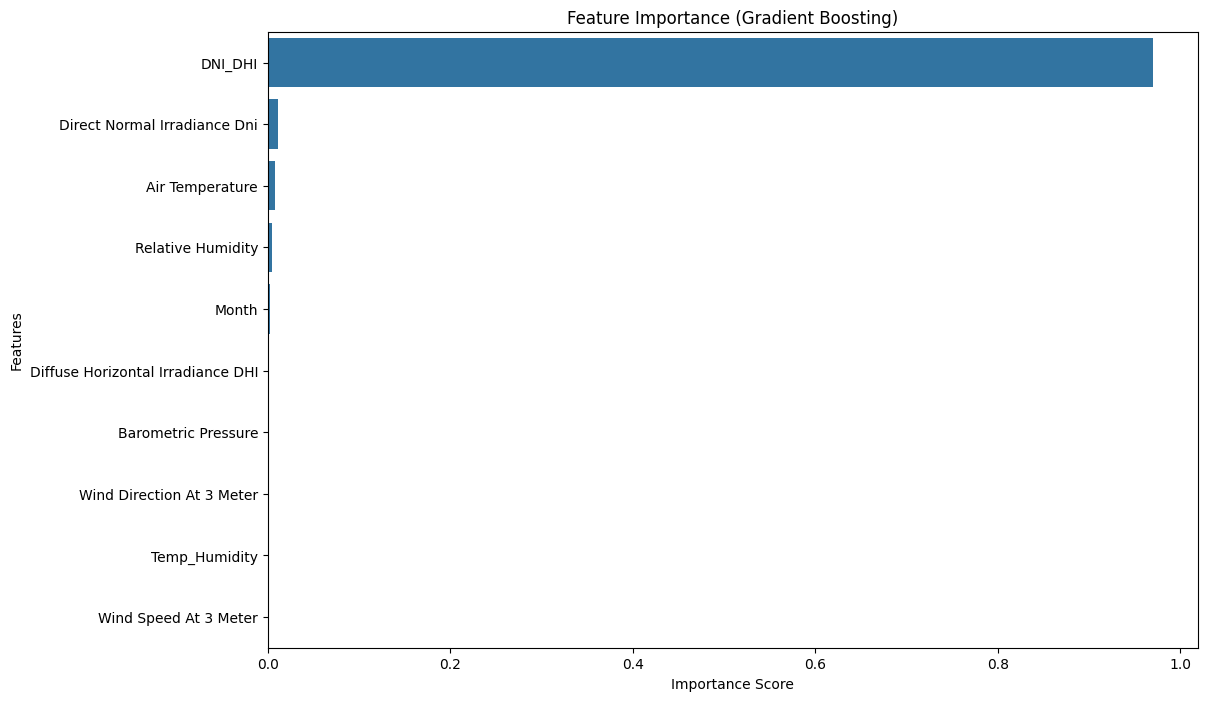

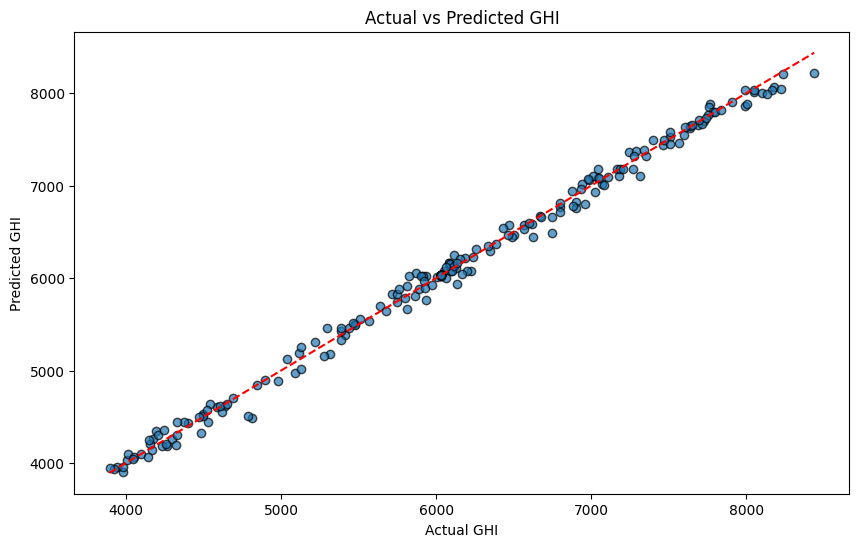

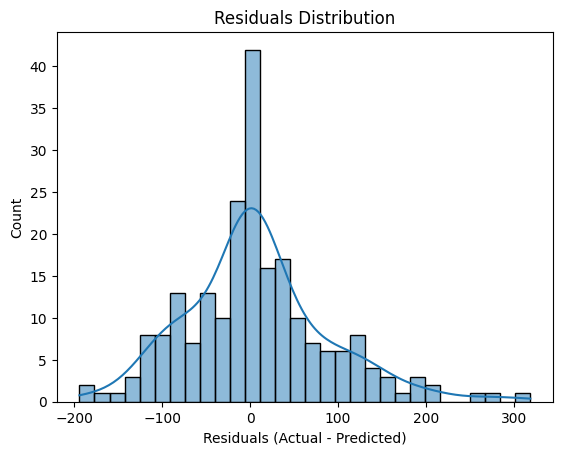

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('Middle_region_data.csv')
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
df['Year'] = df['Time Stamp'].dt.year
df['Month'] = df['Time Stamp'].dt.month
df['Day'] = df['Time Stamp'].dt.day
df['Hour'] = df['Time Stamp'].dt.hour
df = df.fillna(df.mean(numeric_only=True))
df = df.drop(columns=['Time Stamp', 'Source', 'Region'])

# Define features and target
features = ['Direct Normal Irradiance Dni', 'Diffuse Horizontal Irradiance DHI', 'Air Temperature',
            'Wind Direction At 3 Meter', 'Wind Speed At 3 Meter', 'Relative Humidity',
            'Barometric Pressure', 'Month']
target = 'Global Horizontal Irradiance GHI'

# Feature Engineering: Adding interaction features
df['DNI_DHI'] = df['Direct Normal Irradiance Dni'] * df['Diffuse Horizontal Irradiance DHI']
df['Temp_Humidity'] = df['Air Temperature'] * df['Relative Humidity']

# Scaling the features
scaler = StandardScaler()
X = df[features + ['DNI_DHI', 'Temp_Humidity']]
y = df[target]
X = scaler.fit_transform(X)

# Handling outliers in the target variable
q1, q3 = np.percentile(y, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
y = np.clip(y, lower_bound, upper_bound)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter grid
gb_param_dist = {
    'n_estimators': np.arange(100, 501, 50),  # Number of trees
    'max_depth': np.arange(3, 11),  # Depth of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size for updates
    'min_samples_split': np.arange(2, 11),  # Min samples required to split
    'min_samples_leaf': np.arange(1, 6)  # Min samples required in a leaf node
}

# Randomized Search for hyperparameter tuning
gb_search = RandomizedSearchCV(
    gb_model,
    gb_param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1
)

# Fit the model
gb_search.fit(X_train, y_train)

# Best Gradient Boosting model
best_gb_model = gb_search.best_estimator_

# Evaluate the best model
y_pred = best_gb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Cross-validation for model robustness
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_gb_model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Print results
print(f"Best Parameters: {gb_search.best_params_}")
print(f"Cross-Validation MAE: {-np.mean(cv_scores):.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")

# Feature Importance
feature_importance = best_gb_model.feature_importances_
feature_names = features + ['DNI_DHI', 'Temp_Humidity']

# Plotting Feature Importance
plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Scatter plot for actual vs predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_test,y=y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted GHI")
plt.xlabel("Actual GHI")
plt.ylabel("Predicted GHI")
plt.show()

residuals = y_test - y_pred
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
57 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best Parameters: {'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9}
Cross-Validation MAE: 93.83
Test MAE: 84.68
Test RMSE: 118.31
Test MAPE: 1.41%


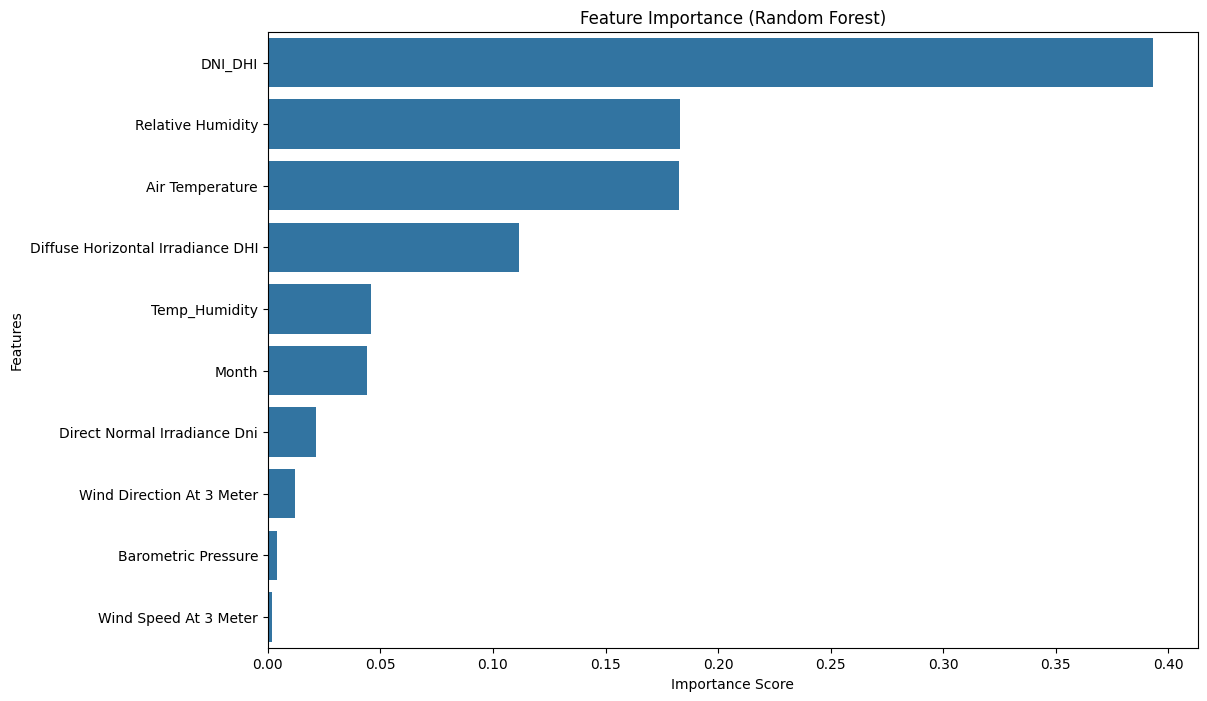

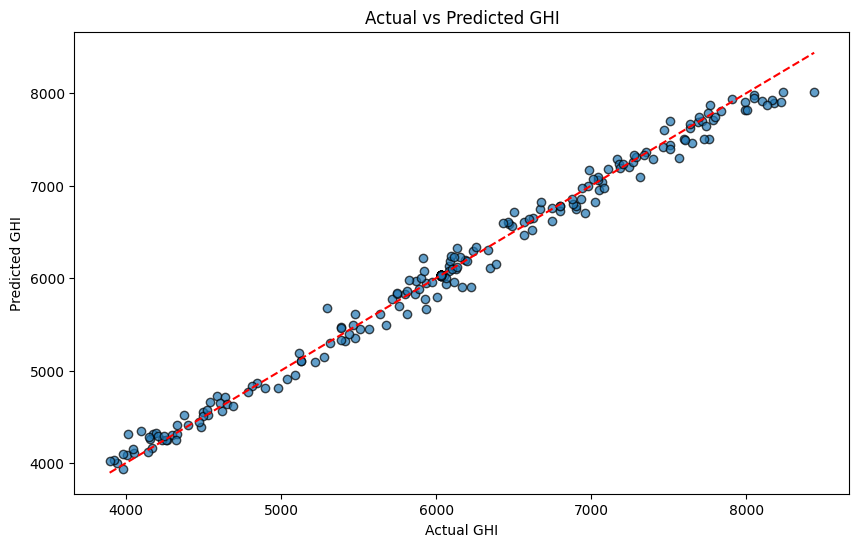

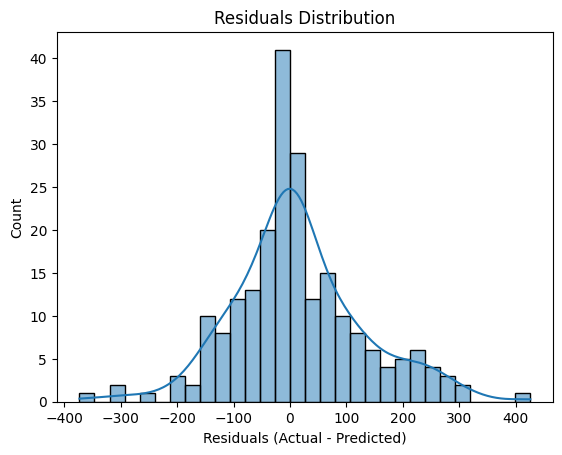

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('Middle_region_data.csv')
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
df['Year'] = df['Time Stamp'].dt.year
df['Month'] = df['Time Stamp'].dt.month
df['Day'] = df['Time Stamp'].dt.day
df['Hour'] = df['Time Stamp'].dt.hour
df = df.fillna(df.mean(numeric_only=True))
df = df.drop(columns=['Time Stamp', 'Source', 'Region'])

# Define features and target
features = ['Direct Normal Irradiance Dni', 'Diffuse Horizontal Irradiance DHI', 'Air Temperature',
            'Wind Direction At 3 Meter', 'Wind Speed At 3 Meter', 'Relative Humidity',
            'Barometric Pressure', 'Month']
target = 'Global Horizontal Irradiance GHI'

# Feature Engineering: Adding interaction features
df['DNI_DHI'] = df['Direct Normal Irradiance Dni'] * df['Diffuse Horizontal Irradiance DHI']
df['Temp_Humidity'] = df['Air Temperature'] * df['Relative Humidity']

# Scaling the features
scaler = StandardScaler()
X = df[features + ['DNI_DHI', 'Temp_Humidity']]
y = df[target]
X = scaler.fit_transform(X)

# Handling outliers in the target variable
q1, q3 = np.percentile(y, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
y = np.clip(y, lower_bound, upper_bound)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
rf_param_dist = {
    'n_estimators': np.arange(100, 501, 50),  # Number of trees
    'max_depth': np.arange(3, 11),  # Depth of trees
    'min_samples_split': np.arange(2, 11),  # Min samples required to split
    'min_samples_leaf': np.arange(1, 6),  # Min samples required in a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features considered at split
}

# Randomized Search for hyperparameter tuning
rf_search = RandomizedSearchCV(
    rf_model,
    rf_param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1
)

# Fit the model
rf_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_search.best_estimator_

# Evaluate the best model
y_pred = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Cross-validation for model robustness
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Print results
print(f"Best Parameters: {rf_search.best_params_}")
print(f"Cross-Validation MAE: {-np.mean(cv_scores):.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")

# Feature Importance
feature_importance = best_rf_model.feature_importances_
feature_names = features + ['DNI_DHI', 'Temp_Humidity']

# Plotting Feature Importance
plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Scatter plot for actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted GHI")
plt.xlabel("Actual GHI")
plt.ylabel("Predicted GHI")
plt.show()

residuals = y_test - y_pred
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.show()